In [2]:
# How long will I be on hold?
#   - Which age group checks out the most books? Which age groups has the highest renewal rate (# ttl renewals/# ttl checkouts)
#   - Which library branch gets the most checkouts?
#   - Can the library branch and the average number of checkouts be used to estimate the age group of the patron?

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline


In [4]:
#load and take a look at the dataset
df = pd.read_csv('Library_Usage.csv');
df.head()

,Patron Type Code,Patron Type Definition,Total Checkouts,Total Renewals,Age Range,Home Library Code,Home Library Definition,Circulation Active Month,Circulation Active Year,Notice Preference Code,Notice Preference Definition,Provided Email Address,Year Patron Registered,Outside of County,Supervisor District
0,3,SENIOR,28,13,65 to 74 years,X,Main Library,November,2012,z,email,True,2003,True,NaN
1,0,ADULT,21,10,55 to 59 years,X,Main Library,October,2015,z,email,True,2003,False,NaN
2,0,ADULT,275,559,60 to 64 years,X,Main Library,January,2015,z,email,True,2003,True,NaN
3,0,ADULT,73,38,45 to 54 years,M8,Mission Bay,February,2016,z,email,True,2003,False,NaN
4,0,ADULT,182,90,45 to 54 years,X,Main Library,July,2016,z,email,True,2003,False,NaN


In [5]:
df.shape

(423448, 15)

In [6]:
df.describe()

,Patron Type Code,Total Checkouts,Total Renewals,Year Patron Registered,Supervisor District
count,423448.000000,423448.000000,423448.000000,423448.000000,313138.000000
mean,1.036765,161.982097,59.657327,2010.348917,6.288240
std,4.188198,453.703678,225.009917,4.357374,3.123634
min,0.000000,0.000000,0.000000,2003.000000,1.000000
25%,0.000000,2.000000,0.000000,2007.000000,4.000000
50%,0.000000,19.000000,2.000000,2012.000000,6.000000
75%,1.000000,113.000000,27.000000,2014.000000,9.000000
max,104.000000,35907.000000,8965.000000,2016.000000,11.000000


In [7]:
df.dtypes

Patron Type Code                  int64
Patron Type Definition           object
Total Checkouts                   int64
Total Renewals                    int64
Age Range                        object
Home Library Code                object
Home Library Definition          object
Circulation Active Month         object
Circulation Active Year          object
Notice Preference Code           object
Notice Preference Definition     object
Provided Email Address             bool
Year Patron Registered            int64
Outside of County                  bool
Supervisor District             float64
dtype: object

In [8]:
#which columns have missing values?
df.isnull().sum()


Patron Type Code                     0
Patron Type Definition               0
Total Checkouts                      0
Total Renewals                       0
Age Range                          215
Home Library Code                   40
Home Library Definition              0
Circulation Active Month             0
Circulation Active Year              0
Notice Preference Code               0
Notice Preference Definition         0
Provided Email Address               0
Year Patron Registered               0
Outside of County                    0
Supervisor District             110310
dtype: int64

In [9]:
#Notice a couple of things:
# Lots of categorical variables in this data set
# Missing values in Supervisor District column and age_range column
# Average # checkouts per patron is 162 and average # of renewals is 60 per person;
# space in headers
# some repetative columns
# Circulation Active Year is an object not a numerical



In [10]:
# Let's do some data clean up
# I noticed the headers of all columns include spaces, get rid of spaces and make all lower case for easier referencing
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.lower()
df.head()

,patron_type_code,patron_type_definition,total_checkouts,total_renewals,age_range,home_library_code,home_library_definition,circulation_active_month,circulation_active_year,notice_preference_code,notice_preference_definition,provided_email_address,year_patron_registered,outside_of_county,supervisor_district
0,3,SENIOR,28,13,65 to 74 years,X,Main Library,November,2012,z,email,True,2003,True,NaN
1,0,ADULT,21,10,55 to 59 years,X,Main Library,October,2015,z,email,True,2003,False,NaN
2,0,ADULT,275,559,60 to 64 years,X,Main Library,January,2015,z,email,True,2003,True,NaN
3,0,ADULT,73,38,45 to 54 years,M8,Mission Bay,February,2016,z,email,True,2003,False,NaN
4,0,ADULT,182,90,45 to 54 years,X,Main Library,July,2016,z,email,True,2003,False,NaN


In [11]:
#I also notice some  repetative information in some columns, such as Home_Library_Code and Home_Library_Definition. I don't really want to
#keep the code so I'll just keep the definitions. I also notice that the data for Supervisor District is not in the file,
#so I'll go ahead and drop that column as well

df.drop(['home_library_code','notice_preference_code'], axis =1,inplace = True)
df.head()


,patron_type_code,patron_type_definition,total_checkouts,total_renewals,age_range,home_library_definition,circulation_active_month,circulation_active_year,notice_preference_definition,provided_email_address,year_patron_registered,outside_of_county,supervisor_district
0,3,SENIOR,28,13,65 to 74 years,Main Library,November,2012,email,True,2003,True,NaN
1,0,ADULT,21,10,55 to 59 years,Main Library,October,2015,email,True,2003,False,NaN
2,0,ADULT,275,559,60 to 64 years,Main Library,January,2015,email,True,2003,True,NaN
3,0,ADULT,73,38,45 to 54 years,Mission Bay,February,2016,email,True,2003,False,NaN
4,0,ADULT,182,90,45 to 54 years,Main Library,July,2016,email,True,2003,False,NaN


In [12]:
#clean up the circualtion active year to drop all active year = None
df.circulation_active_year[df.circulation_active_year == 'None'].count()/df.shape[0]


0.16035971358938997

In [13]:
#16% of the circulative active year is None!
# I feel this is a lot of missing data to impute so I am going to be safe and not use data with this information missing. 
df.circulation_active_year = np.where(df.circulation_active_year == 'None', None, df.circulation_active_year)

In [14]:
df.dropna(subset = ['circulation_active_year'], axis = 0, inplace = True)

In [15]:
df = df.astype({"circulation_active_year": int})

In [16]:
df.dtypes

patron_type_code                  int64
patron_type_definition           object
total_checkouts                   int64
total_renewals                    int64
age_range                        object
home_library_definition          object
circulation_active_month         object
circulation_active_year           int64
notice_preference_definition     object
provided_email_address             bool
year_patron_registered            int64
outside_of_county                  bool
supervisor_district             float64
dtype: object

In [17]:
# How does the number of average total checkouts vary between age_range?
# How does the average total renewals to total checkouts ratio = renewal rate vary between age_range?
# Do supervisor districts have any effect on the above trends?
# Can I predict a users  approx. renewal rate base on age_range and home library, etc.?

#Additional Questions from a business standpoint:
#Which age group has the activity rate = ttl_checkouts/ttl_active_yrs (active yr - yr registered)



In [18]:
#Does the number of average total checkouts vary between age_range?
df.groupby('age_range').total_checkouts.mean().sort_values()
#Looks like 75 and over years has the most check outs average checkouts.
#Though if older patrons have been with the libraries longer, this would may be true just due to time.
#Therefore, average yearly might be a better number for comparison

age_range
25 to 34 years        63.330362
35 to 44 years       132.140065
20 to 24 years       135.212104
0 to 9 years         153.723500
45 to 54 years       227.055236
10 to 19 years       269.106897
55 to 59 years       289.105999
60 to 64 years       324.317297
65 to 74 years       351.632331
75 years and over    369.113091
Name: total_checkouts, dtype: float64

In [19]:
df['years_active'] = df.circulation_active_year - df.year_patron_registered
df.head()

,patron_type_code,patron_type_definition,total_checkouts,total_renewals,age_range,home_library_definition,circulation_active_month,circulation_active_year,notice_preference_definition,provided_email_address,year_patron_registered,outside_of_county,supervisor_district,years_active
0,3,SENIOR,28,13,65 to 74 years,Main Library,November,2012,email,True,2003,True,NaN,9
1,0,ADULT,21,10,55 to 59 years,Main Library,October,2015,email,True,2003,False,NaN,12
2,0,ADULT,275,559,60 to 64 years,Main Library,January,2015,email,True,2003,True,NaN,12
3,0,ADULT,73,38,45 to 54 years,Mission Bay,February,2016,email,True,2003,False,NaN,13
4,0,ADULT,182,90,45 to 54 years,Main Library,July,2016,email,True,2003,False,NaN,13


In [21]:
#make assumption that if person was last active in the same year they registered, automatically 1 year active
df.years_active = np.where(df.years_active == 0, 1, df.years_active)

In [22]:
df['yearly_checkouts'] = df.total_checkouts/df.years_active


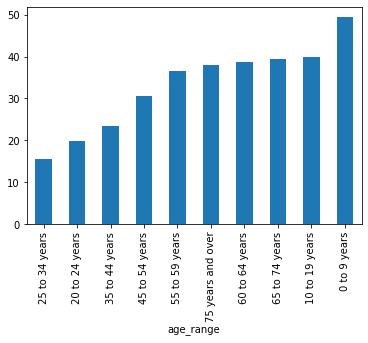

In [32]:
df.groupby('age_range').yearly_checkouts.mean().sort_values().plot(kind ='bar');

In [24]:
#Add another column for renewal rate, the approx. times per checkout that someone has renewed their checkout
df['renewal_rate'] = df.total_renewals/df.total_checkouts
df.describe()

,patron_type_code,total_checkouts,total_renewals,circulation_active_year,year_patron_registered,supervisor_district,years_active,yearly_checkouts,renewal_rate
count,355544.000000,355544.000000,355544.000000,355544.000000,355544.000000,275257.000000,355544.000000,355544.000000,349852.000000
mean,0.964533,192.918249,71.051029,2014.724943,2009.646629,6.285896,5.261236,29.918769,0.423422
std,4.103236,489.073558,243.904662,1.567938,4.348615,3.133139,4.255645,60.458448,0.636155
min,0.000000,0.000000,0.000000,2003.000000,2003.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,7.000000,0.000000,2014.000000,2006.000000,4.000000,1.000000,3.000000,0.000000
50%,0.000000,34.000000,6.000000,2015.000000,2011.000000,7.000000,4.000000,9.416667,0.156098
75%,1.000000,155.000000,39.000000,2016.000000,2013.000000,9.000000,9.000000,30.000000,0.593985
max,104.000000,35907.000000,8965.000000,2016.000000,2016.000000,11.000000,13.000000,3736.000000,9.000000


In [25]:
#Are any nulls added with the new column?
df.renewal_rate.isnull().sum()


5692

In [26]:
#I assume that the above happens with a person has no checkouts
#and therefore has nothing to renew, resulting in a divided by zero situation
# Now to decide how I want to subsitute this information.
#I want my analysis to only involve "Active" users, which I will define as having at
#least one checkout. Therefore, I will choose to drop all columns that have a renewal rate of null
df = df.dropna(subset = ["renewal_rate"], axis = 0)
df.shape

(349852, 16)

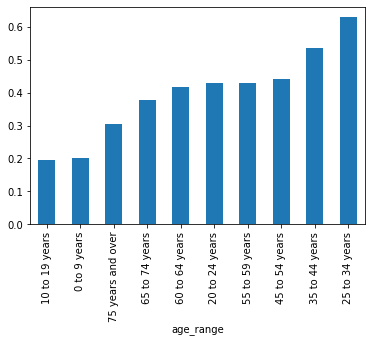

In [33]:
#Which age group has the largest renewal rate?
df.groupby('age_range').renewal_rate.mean().sort_values().plot(kind = 'bar');

#It's interesting: 25 to 34 years has the largest renewal to checkout ratio

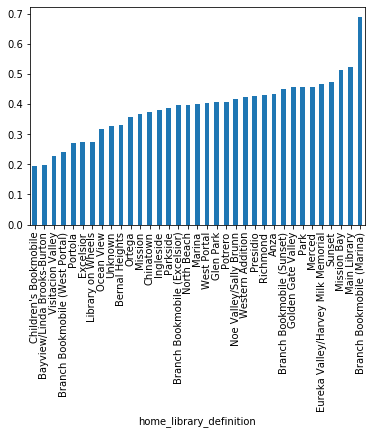

In [34]:
# ok so now I know approximately how long I would have to wait for an item if I knew what age group the person was in,
# but does it matter what the home library is?
df.groupby('home_library_definition').renewal_rate.mean().sort_values().plot(kind = 'bar');

In [42]:
df.groupby(['home_library_definition','age_range']).renewal_rate.mean().sort_values()

home_library_definition          age_range        
Library on Wheels                10 to 19 years       0.000000
Branch Bookmobile (West Portal)  60 to 64 years       0.000000
Branch Bookmobile (Excelsior)    0 to 9 years         0.038911
                                 75 years and over    0.058577
Branch Bookmobile (Marina)       75 years and over    0.083521
                                                        ...   
Branch Bookmobile (Excelsior)    25 to 34 years       0.730472
                                 35 to 44 years       1.006500
Branch Bookmobile (Sunset)       20 to 24 years       1.268874
                                 55 to 59 years       1.398467
Branch Bookmobile (Marina)       25 to 34 years       1.945055
Name: renewal_rate, Length: 343, dtype: float64

In [46]:
#lets take a look at patron type
df.groupby('patron_type_definition').renewal_rate.mean().sort_values()


patron_type_definition
JUVENILE               0.183188
YOUNG ADULT            0.198338
DIGITAL ACCESS CARD    0.198807
AT USER JUVENILE       0.238094
TEACHER CARD           0.247743
VISITOR                0.266020
WELCOME                0.285859
SPECIAL                0.287446
AT USER WELCOME        0.310541
AT USER TEEN           0.349852
SENIOR                 0.351926
BOOKS BY MAIL          0.398103
AT USER ADULT          0.421769
RETIRED STAFF          0.482747
ADULT                  0.522067
AT USER SENIOR         0.614742
FRIENDS FOR LIFE       0.616279
STAFF                  0.684836
Name: renewal_rate, dtype: float64

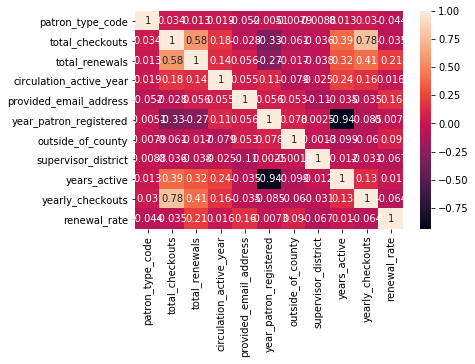

In [39]:
sns.heatmap(df.corr(), annot = True);

In [51]:
df.dropna(subset = ['age_range'], axis = 0, inplace = True)

In [52]:
df.dropna(subset =['home_library_definition'], axis = 0, inplace = True)

In [56]:
df.head()

,patron_type_code,patron_type_definition,total_checkouts,total_renewals,age_range,home_library_definition,circulation_active_month,circulation_active_year,notice_preference_definition,provided_email_address,year_patron_registered,outside_of_county,supervisor_district,years_active,yearly_checkouts,renewal_rate
0,3,SENIOR,28,13,65 to 74 years,Main Library,November,2012,email,True,2003,True,NaN,9,3.111111,0.464286
1,0,ADULT,21,10,55 to 59 years,Main Library,October,2015,email,True,2003,False,NaN,12,1.750000,0.476190
2,0,ADULT,275,559,60 to 64 years,Main Library,January,2015,email,True,2003,True,NaN,12,22.916667,2.032727
3,0,ADULT,73,38,45 to 54 years,Mission Bay,February,2016,email,True,2003,False,NaN,13,5.615385,0.520548
4,0,ADULT,182,90,45 to 54 years,Main Library,July,2016,email,True,2003,False,NaN,13,14.000000,0.494505


In [106]:
df.drop(['supervisor_district'], axis =1,inplace = True)

In [102]:
df_model = df[['home_library_definition','patron_type_definition','age_range','renewal_rate']]

In [86]:

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    
    df = pd.get_dummies(df, columns = cat_cols, dummy_na = dummy_na, drop_first= True)

    return df

In [87]:
def clean_fit_linear_mod(df,response_col, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    Your function should:
    1. Drop the rows with missing response values
    2. Drop columns with NaN for all the values
    3. Use create_dummy_df to dummy categorical columns
    4. Fill the mean of the column for any missing values 
    5. Split your data into an X matrix and a response vector y
    6. Create training and test sets of data
    7. Instantiate a LinearRegression model with normalized data
    8. Fit your model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''
   # df_drop = df.dropna(subset = [response_col], axis = 0)
   # df_drop_na = df_drop.loc[:,((df_drop.isna().sum()/df_drop.shape[0]) == 1)== False]
    cat_df = df.select_dtypes(include = ['object'])
    cat_cols = cat_df.columns

    df_dummy = create_dummy_df(df, cat_cols, dummy_na = dummy_na)

    #fill_mean = lambda col: col.fillna(col.mean())

    #df_dummy_fill = df_dummy.apply(fill_mean, axis = 0)

    X = df_dummy.drop(response_col, axis = 1)
    y = df_dummy[response_col]

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = test_size, random_state = rand_state)

    lm_model = LinearRegression(normalize = True)
    lm_model.fit(X_train,y_train)
    y_preds = lm_model.predict(X_test)
    test_score = r2_score(y_test, y_preds)
    y_preds_train = lm_model.predict(X_train)
    train_score = r2_score(y_train, y_preds_train)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test


In [107]:
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df,'renewal_rate', dummy_na=False, test_size=.3, rand_state=42);





In [108]:
test_score,train_score

(0.1600276573305477, 0.15922404612147312)

In [95]:
test_score,train_score

(0.058438996999280124, 0.05859826671033885)

In [89]:
test_score,train_score

(0.0684967906250753, 0.06680788439820684)